In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plorts
import matplotlib
from common import *

plt.style.use(['plorts', 'plorts-print', './buffer-workshop.mplstyle'])
width = 7.141/2
matplotlib.rcParams['figure.figsize'] = (width, width*1/3)

In [3]:
prr = pd.read_sql("""
select traces.timestamp_sec,
  --was_dropped,
  --round(postcard_traces.queue_depth_packets) as queue_depth_packets,
  snd_cwnd,
  traces.snd_una,
  traces.snd_nxt,
  experiments.*
  
from (
    select experiment_id, snd_nxt, snd_una, snd_cwnd, timestamp_sec
    from traces
    where experiment_id = '8bfa0b54-90cf-11ea-8dea-0cc47aaaaa10'
    --group by experiment_id, snd_una, snd_cwnd
  ) as traces
  --on traces.experiment_id = postcard_traces.experiment_id
  --and traces.snd_nxt = postcard_traces.seq_no

inner join experiments on experiments.id = traces.experiment_id
""", con=con)

KeyboardInterrupt: 

In [ ]:
prr_postcards = pd.read_sql("""
select postcard_traces.timestamp_sec,
  was_dropped,
  round(postcard_traces.queue_depth_packets) as queue_depth_packets,
  seq_no,
  experiments.*
  
from postcard_traces
inner join experiments on experiments.id = postcard_traces.experiment_id

where postcard_traces.experiment_id = '8bfa0b54-90cf-11ea-8dea-0cc47aaaaa10'
""", con=con)

In [5]:
prr_retransmits = pd.read_sql("""
select * from retransmits
inner join experiments on experiments.id = experiment_id
where experiment_id = '8bfa0b54-90cf-11ea-8dea-0cc47aaaaa10'
""", con=con)
prr_retransmits.head()

,index,daddr,daddrv6,dport,saddr,saddrv6,sport,state,absolute_timestamp,experiment_id,...,max_queue_depth_cells,max_queue_depth_packets,mtu_bytes,num_flows,receiver_delay,note,run_at,pacing,pacing_factor,experimenter
0,None,10.0.0.1,::ffff:10.0.0.1,5201,10.0.1.1,::ffff:10.0.1.1,60046,TCP_ESTABLISHED,4.937756e+06,8bfa0b54-90cf-11ea-8dea-0cc47aaaaa10,...,18675,166.0,9000,1,1ms,postcard,2020-05-07 18:59:49.348682,False,1.0,bspang
1,None,10.0.0.1,::ffff:10.0.0.1,5201,10.0.1.1,::ffff:10.0.1.1,60046,TCP_ESTABLISHED,4.937756e+06,8bfa0b54-90cf-11ea-8dea-0cc47aaaaa10,...,18675,166.0,9000,1,1ms,postcard,2020-05-07 18:59:49.348682,False,1.0,bspang
2,None,10.0.0.1,::ffff:10.0.0.1,5201,10.0.1.1,::ffff:10.0.1.1,60046,TCP_ESTABLISHED,4.937756e+06,8bfa0b54-90cf-11ea-8dea-0cc47aaaaa10,...,18675,166.0,9000,1,1ms,postcard,2020-05-07 18:59:49.348682,False,1.0,bspang
3,None,10.0.0.1,::ffff:10.0.0.1,5201,10.0.1.1,::ffff:10.0.1.1,60046,TCP_ESTABLISHED,4.937756e+06,8bfa0b54-90cf-11ea-8dea-0cc47aaaaa10,...,18675,166.0,9000,1,1ms,postcard,2020-05-07 18:59:49.348682,False,1.0,bspang
4,None,10.0.0.1,::ffff:10.0.0.1,5201,10.0.1.1,::ffff:10.0.1.1,60046,TCP_ESTABLISHED,4.937756e+06,8bfa0b54-90cf-11ea-8dea-0cc47aaaaa10,...,18675,166.0,9000,1,1ms,postcard,2020-05-07 18:59:49.348682,False,1.0,bspang


In [6]:
start = 1.682

bdp = 166.6
buffer = prr.iloc[0].max_queue_depth_packets

prr['time_ms'] = (prr["timestamp_sec"] - start)*1000
prr_postcards["time_ms"] = (prr_postcards["timestamp_sec"] - start)*1000
prr_retransmits["time_ms"] = (prr_retransmits["timestamp_sec"] - start)*1000

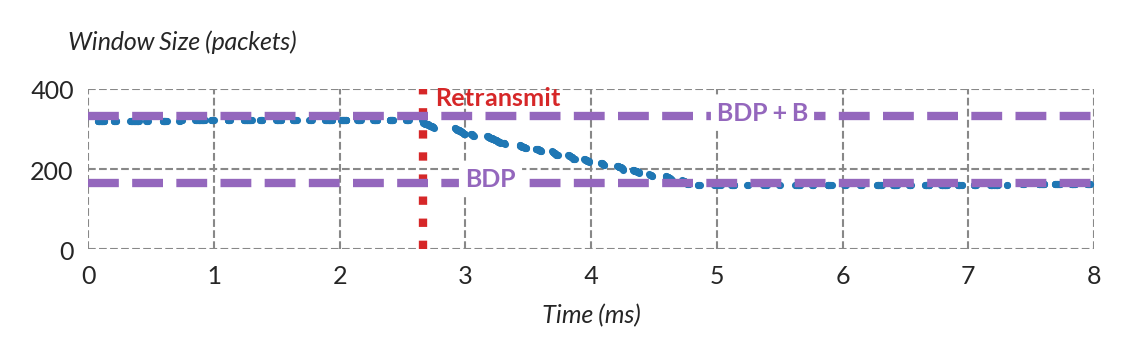

In [7]:
plt.figure(figsize=(width, 1/4*width))

#plt.subplot(2,1,1)
plt.scatter(prr.time_ms, prr.snd_cwnd, color='C0', s=0.5)
#plt.xlabel("Time (ms)")
#plt.gca().get_xaxis().set_visible(False)
#plt.xticks(range(9),[])
plt.xlabel("Time (ms)")
plt.ylabel("Window Size (packets)")
plt.axis(xmin=0, xmax=8, ymin=0, ymax=400)

retrans = prr_retransmits[prr_retransmits.time_ms >= 0]
retrans = retrans[retrans.time_ms <= 8]
r = retrans.iloc[0]
plt.axvline(x=r.time_ms, linestyle=":", color='C3')
plt.text(r.time_ms+0.1, 360, "Retransmit", color='C3', fontweight='bold', fontsize=6)

plt.axhline(y=(bdp + buffer), linestyle="--", color='C4')
plt.text(5, (bdp+buffer)-10, "BDP + B", color='C4', fontweight='bold',
         bbox=dict(facecolor='white', edgecolor='white', pad=1))

plt.axhline(y=bdp, label="BDP", linestyle="--", color='C4')
plt.text(3, (bdp)-10, "BDP", color='C4', fontweight='bold',
         bbox=dict(facecolor='white', edgecolor='white', pad=1))

plorts.style_axis(show_xaxis=True)

plorts.savefig("../figures/traces/prr.png")

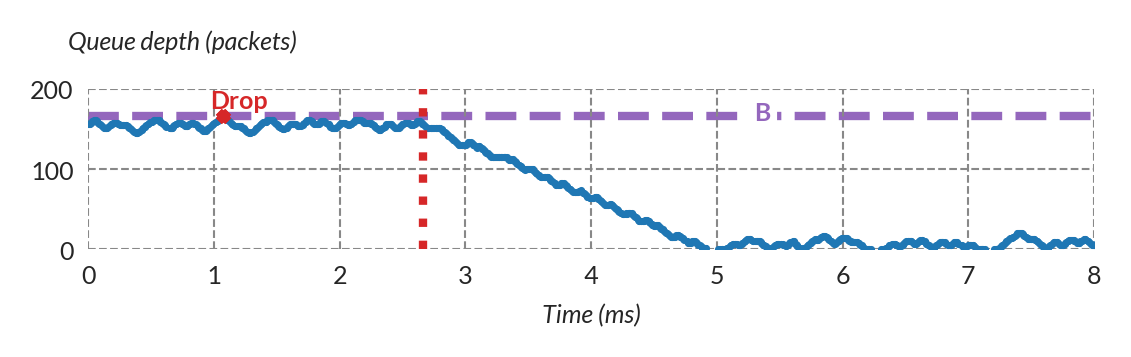

In [8]:
plt.figure(figsize=(width, 1/4*width))

plt.axhline(y=buffer, linestyle="--", color='C4', zorder=0)
plt.text(5.3, buffer-5, "B", color="C4", bbox=dict(facecolor='white', edgecolor='white', pad=1), fontweight='bold')

plt.scatter((prr_postcards[prr_postcards.was_dropped == 0].time_ms), prr_postcards[prr_postcards.was_dropped == 0].queue_depth_packets,
            s=0.5, zorder=1)
plt.scatter((prr_postcards[prr_postcards.was_dropped == 1].time_ms), prr_postcards[prr_postcards.was_dropped == 1].queue_depth_packets,
            marker='x', s=5, color='C3', zorder=2)
plt.xlabel("Time (ms)")
plt.ylabel("Queue depth (packets)")

plorts.style_axis(show_xaxis=True)
plt.axis(xmin=0, xmax=8,ymin=0,ymax=200)
#plt.legend(loc='upper right')

retrans = prr_retransmits[prr_retransmits.time_ms >= 0]
retrans = retrans[retrans.time_ms <= 8]
r = retrans.iloc[0]
plt.axvline(x=r.time_ms, label="Retransmit", linestyle=":", color='C3')

plt.text(0.97, buffer+10, "Drop", color='C3', fontsize=6, fontweight='bold')

#plorts.legend(loc='inline')

plorts.savefig("../figures/traces/prr-queue.png")